In [1]:
import pickle
import pandas as pd 
import numpy as np
import torch
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from openbabel import pybel
import re

In [2]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
import sys
sys.path.append('..')

In [4]:
from utils_eval import build_pdb_dict, pp_match, extract_pp, group_by
from pp_matching_specific_site import compute_center
from data_processing.ligand import Ligand

In [5]:
# ligand_name = '1ywn_A_rec_1ywn_lif_lig_tt_docked_0'  # 0 0
# ligand_name = '4b81_B_rec_4ara_c56_lig_tt_min_0'  # 0.41 0.51
# ligand_name = '1lhu_A_rec_1lhn_aon_lig_tt_min_0'  # 0.07 0.11
# ligand_name = '4b84_A_rec_4b84_z5k_lig_tt_min_0'  # 0.60 0.61
# ligand_name = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0'  
# ligand_name = '5hbh_A_rec_5idn_6a7_lig_tt_min_0'
# ligand_name = '5aen_A_rec_5ni2_dj3_lig_tt_min_0'
# ligand_name = '3d3e_B_rec_4ijw_1eq_lig_tt_min_0'
# ligand_name = '4yyz_B_rec_3ey4_352_lig_tt_docked_12'
ligand_name = '4h7c_A_rec_3r58_nps_lig_tt_min_0'  # 0.64 0.70
# ligand_name = '3ey4_C_rec_4k1l_sff_lig_tt_min_0'  # 0.59 0.59 

In [13]:
ligand_name = 'test4'

In [7]:
root_path = os.path.join('structure_based', ligand_name)
# root_path = os.path.join('ligand_based', ligand_name)
aromatic = True
gen_path = os.path.join(root_path, 'aromatic' if aromatic else 'basic')

In [8]:
score_file = os.path.join(root_path, 'aromatic_matches.pkl' if aromatic else 'basic_matches.pkl')
with open(score_file, 'rb') as f:
    matches = pickle.load(f)
matches

{'3r58_32': array([1, 1, 0, 0, 0, 0, 0]),
 '3r58_41': array([1, 1, 0, 1, 0, 0, 0]),
 '3r58_307': array([1, 1, 1, 1, 0, 0, 0]),
 '3r58_50': array([0, 1, 1, 1, 0, 0, 0]),
 '3r58_466': array([1, 0, 0, 0, 0, 0, 0]),
 '3r58_342': array([1, 1, 1, 1, 0, 0, 0]),
 '3r58_294': array([1, 1, 1, 0, 0, 0, 0]),
 '3r58_65': array([1, 1, 0, 0, 0, 0, 0]),
 '3r58_201': array([1, 0, 1, 0, 0, 0, 0]),
 '3r58_409': array([1, 1, 1, 0, 0, 0, 0]),
 '3r58_140': array([1, 1, 1, 1, 0, 0, 0]),
 '3r58_174': array([0, 0, 1, 0, 0, 0, 0]),
 '3r58_302': array([1, 1, 1, 1, 0, 0, 0]),
 '3r58_481': array([1, 1, 1, 0, 0, 0, 0]),
 '3r58_141': array([1, 1, 0, 1, 0, 0, 0]),
 '3r58_417': array([0, 0, 0, 0, 0, 0, 0]),
 '3r58_101': array([1, 1, 0, 1, 1, 0, 0]),
 '3r58_282': array([1, 1, 0, 1, 0, 0, 0]),
 '3r58_335': array([0, 1, 0, 0, 0, 0, 0]),
 '3r58_440': array([1, 0, 0, 1, 0, 0, 0]),
 '3r58_445': array([1, 1, 0, 0, 0, 0, 0]),
 '3r58_19': array([1, 1, 1, 1, 0, 0, 0]),
 '3r58_165': array([1, 1, 1, 1, 0, 0, 0]),
 '3r58_393': arr

In [ ]:
np.where(arr in matches.values)

In [9]:
test_data = torch.load(os.path.join(root_path, ligand_name + '_aromatic' + '.pt' if aromatic else ligand_name + '.pt'))
center = compute_center(test_data['target_pos'], test_data['Gt_mask'])

with open(os.path.join(root_path, 'pp_info.pkl'), 'rb') as f:
    pp_info = pickle.load(f)

pp_info['pp_positions'] = pp_info['pp_positions'] - center
pp_info['pp_positions']

tensor([[ 0.2859, -1.1823, -0.0523],
        [-0.4000, -1.0198, -1.2720],
        [-0.2426,  1.4622, -0.9949],
        [-0.6268,  0.2942, -1.6918],
        [-0.8078, -2.0420, -3.6587],
        [ 1.0929,  1.1522,  1.3676],
        [-2.9747, -2.6199, -1.6775]])

In [10]:
pp_info['pp_types']

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [12]:
def test_ref_ligand(gen_lig, ori_lig, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, gen_lig+'.sdf')
    m = Chem.MolFromMolFile(gen_lig)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ori_lig+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [33]:
idx = '371'
lig_id = ligand_name[ligand_name.rfind('rec')+4:ligand_name.rfind('rec')+8]
lig_file = os.path.join(gen_path, lig_id + '_' + idx + '.sdf')
lig_file

'structure_based/4h7c_A_rec_3r58_nps_lig_tt_min_0/aromatic/3r58_371.sdf'

In [34]:
matches[lig_id + '_' + idx]

array([1, 1, 1, 1, 0, 1, 0])

In [35]:
rdmol = Chem.MolFromMolFile(lig_file, sanitize=True)
pbmol = next(pybel.readfile("sdf", lig_file))
try:
    # rdmol = Chem.AddHs(rdmol)
    ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False)
except:
    print('ligand init failed')
pp_atom_indices, pp_positions, pp_types, pp_index = extract_pp(ligand)

['Hydrophobic'] [ 0.6709 -0.0381  0.6088]
['Hydrophobic'] [-1.9947  2.0272 -0.6866]
['Hydrophobic'] [ 0.6962 -1.3945  0.9803]
['Hydrophobic'] [ 3.6041 -0.5512  1.6557]
['Hydrophobic'] [-0.6557 -2.1973 -1.7395]
['Hydrophobic'] [1.6715 0.9316 0.9587]
['Hydrophobic'] [2.9696 0.6617 1.4285]
['Hydrophobic'] [ 3.0605 -1.821   1.6598]
['Hydrophobic'] [-1.5819 -0.1919 -0.659 ]
['Hydrophobic'] [1.3673 2.3153 0.8142]
['Hydrophobic'] [-0.5068  0.4562 -0.027 ]
['Hydrophobic'] [-2.507   0.787  -1.0155]
['Hydrophobic'] [-1.6728 -1.5893 -1.1324]
['Hydrophobic'] [-0.7692  1.8071 -0.1018]
['Hydrophobic'] [-3.7589  0.5699 -1.8077]
['Hydrophobic'] [0.1412 2.7551 0.3202]
['Hydrophobic'] [ 1.7446 -2.1789  1.4402]
['Aromatic'] [ 2.0596287 -0.6272     1.2474287]
['Aromatic'] [0.42915002 1.3712001  0.42885002]
['Aromatic'] [-1.47192     0.97712004 -0.49797997]


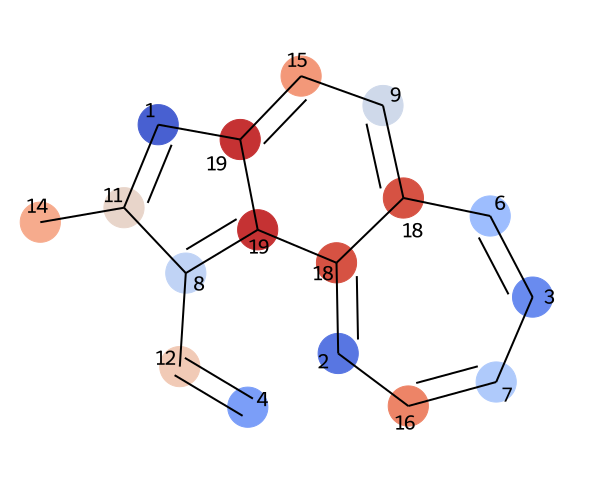

In [36]:
mol_, highlights = group_by(rdmol, ligand)
imgsize = (600, 500)
drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
drawer.DrawMolecule(mol_, **highlights)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:','')))

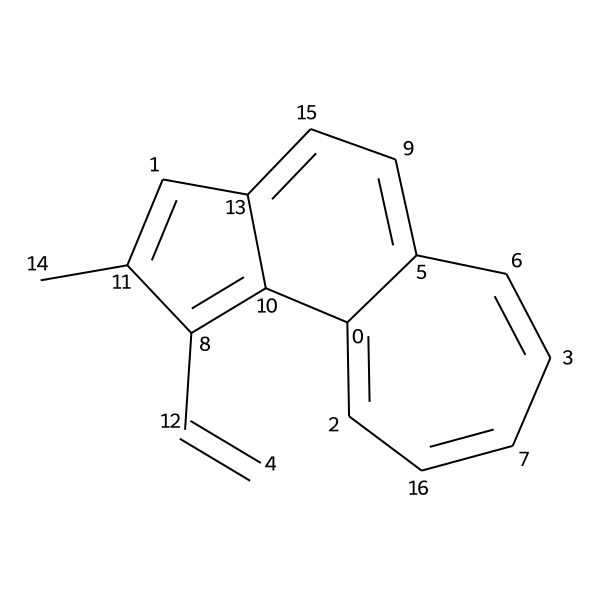

In [37]:
m, ref_m = test_ref_ligand(lig_file, ligand_name)
m

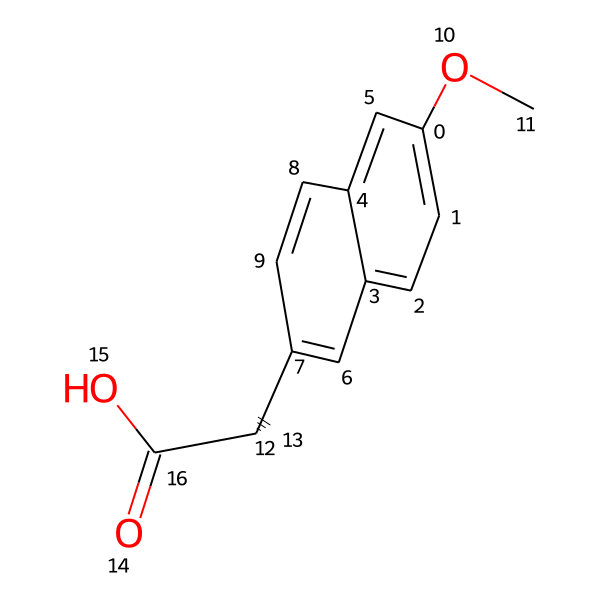

In [38]:
ref_m

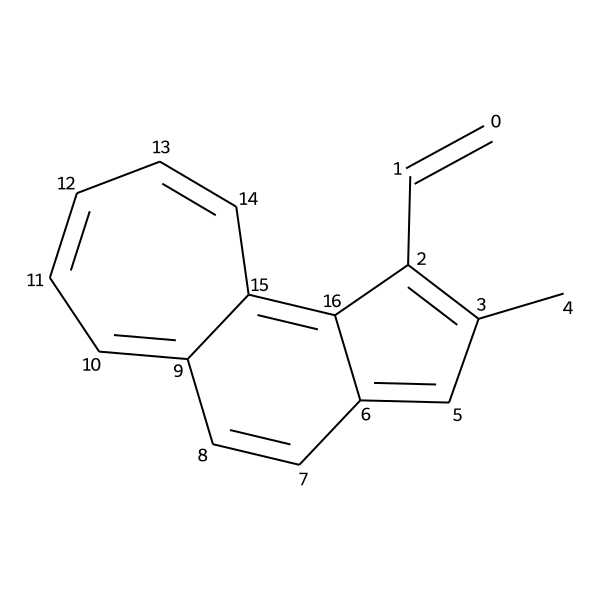

In [39]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

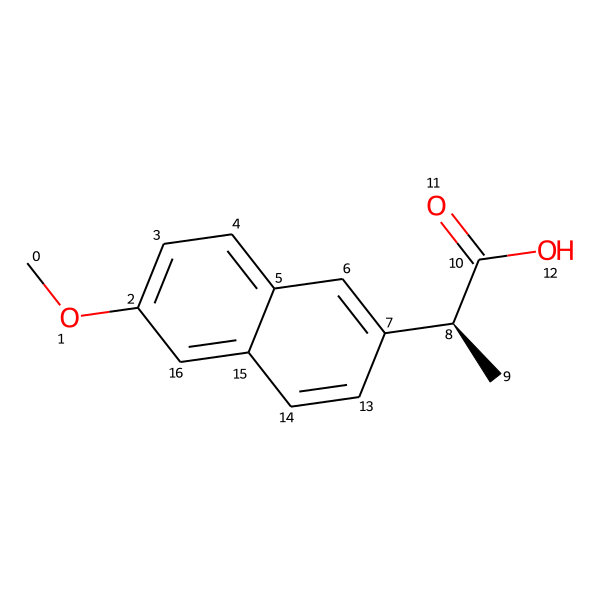

In [40]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [41]:
def compare(gen_lig, ori_lig, gen_path=gen_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ori_lig)
    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    # protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ori_lig[ori_lig.rfind('rec')+4:ori_lig.rfind('lig')+3]
    # autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')
    autobox_ligand_file = os.path.join(root_path, ori_lig+'.sdf')

    ligand_file = gen_lig # os.path.join(gen_path, gen_lig+'.sdf')

    # out_folder = 'output_aromatic' if aromatic else 'output'
    # out_file = os.path.join(root_path, out_folder, gen_lig)
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    v.rotate(90)
    # v.animate({'interval':1000})
    
    return v

In [42]:
compare(lig_file, ligand_name)

4h7c_A_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
def compare_test(gen_lig, ori_lig, gen_path=gen_path):
    gen_lig_file = os.path.join(gen_path, gen_lig+'.sdf')
    ori_lig_file = os.path.join(gen_path, '..', ori_lig+'.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(ori_lig_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(gen_lig_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    # v.rotate(90)

    return v

In [18]:
gen_lig = 't4_359'
compare_test(gen_lig, ligand_name)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.